## Step 1: Define the Environment

In [78]:
import os
import json
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import hashlib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import cryptographic libraries for decryption
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

print("🔐 Q-Learning Medical Decision System")
print("Libraries imported successfully!")


🔐 Q-Learning Medical Decision System
Libraries imported successfully!


In [79]:
# =====================================
# DECRYPTION FUNCTIONS
# =====================================

def stable_json(obj):
    """Convert object to stable JSON bytes representation."""
    return json.dumps(obj, sort_keys=True, separators=(",", ":")).encode("utf-8")

def sha256_hex(data):
    """Compute SHA256 hash and return as hex string."""
    return hashlib.sha256(data).hexdigest()

def hkdf_32(shared, salt, info):
    """Derive 32-byte key using HKDF."""
    hkdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=salt, info=info)
    return hkdf.derive(shared)

def ecies_unwrap_x25519(recipient_sk, wrapped_data):
    """Unwrap key using ECIES with X25519."""
    if len(wrapped_data) != 64:
        raise ValueError("Invalid wrapped data length")
    
    eph_pub_raw = wrapped_data[:32]
    wrapped_key = wrapped_data[32:]
    
    eph_pub = x25519.X25519PublicKey.from_public_bytes(eph_pub_raw)
    shared = recipient_sk.exchange(eph_pub)
    keystream = hkdf_32(shared, salt=b"wrap-salt", info=b"DEK-wrap")
    unwrapped = bytes(a ^ b for a, b in zip(wrapped_key, keystream))
    
    return unwrapped[:32]

def decrypt_blob(blob_data, dek):
    """Decrypt a blob using the provided DEK."""
    ciphertext = base64.b64decode(blob_data['c'])
    tag = base64.b64decode(blob_data['tag'])
    nonce = base64.b64decode(blob_data['nonce'])
    aad = base64.b64decode(blob_data['aad'])
    
    ciphertext_with_tag = ciphertext + tag
    aead = AESGCM(dek)
    plaintext = aead.decrypt(nonce, ciphertext_with_tag, aad)
    
    return json.loads(plaintext.decode('utf-8'))

print("✅ Decryption functions loaded")


✅ Decryption functions loaded


In [80]:
# =====================================
# LOAD AND PROCESS MEDICAL DATA
# =====================================

# Load the actual medical dataset directly
print("📊 Loading actual medical dataset...")
medical_data = pd.read_csv("/Users/lukman/Desktop/Research/medical_dataset.csv")

# Process the data to match expected format
def process_medical_data(df):
    """Process the raw medical dataset to extract features for Q-learning."""
    processed_df = df.copy()
    
    # Extract blood pressure components
    bp_data = processed_df['Blood Pressure_mmHg'].str.split('/', expand=True)
    processed_df['BP_Systolic'] = pd.to_numeric(bp_data[0], errors='coerce').fillna(120)
    processed_df['BP_Diastolic'] = pd.to_numeric(bp_data[1], errors='coerce').fillna(80)
    
    # Map existing columns to expected names
    processed_df['Temperature'] = processed_df['Temperature_C']
    processed_df['HR'] = processed_df['Heart Rate_bpm']
    processed_df['RR'] = processed_df['Respiration Rate_brpm']
    processed_df['SpO2'] = processed_df['SpO2_percent']
    
    # Create ECG features from available ECG data
    processed_df['ECG_Lead_I'] = processed_df['ECG_RR_interval_ms'] / 1000  # Convert to seconds
    processed_df['ECG_Lead_II'] = processed_df['ECG_RR_interval_ms'] / 1200  # Simulated second lead
    
    # Simplify risk categories
    processed_df['Risk'] = processed_df['Risk Level'].map({
        'High Risk for CVD': 'High',
        'Moderate Risk for CVD or Diabetes': 'Medium', 
        'Low Risk': 'Low'
    }).fillna('Medium')
    
    # Use original Patient ID and Action columns
    processed_df['PatientID'] = processed_df['Patient ID']
    
    return processed_df

medical_data = process_medical_data(medical_data)

# Display first 20 records
print("\n" + "="*80)
print("🏥 FIRST 20 PROCESSED MEDICAL RECORDS")
print("="*80)
columns_to_show = ['PatientID', 'Date', 'Temperature', 'BP_Systolic', 'BP_Diastolic', 'HR', 'RR', 'SpO2', 'Risk', 'Action']
print(medical_data[columns_to_show].head(20).to_string(index=False))

print(f"\n📈 Dataset shape: {medical_data.shape}")
print(f"📊 Processed features available: {len(columns_to_show)}")
print(f"🏥 Unique patients: {medical_data['PatientID'].nunique()}")
print(f"📅 Date range: {medical_data['Date'].min()} to {medical_data['Date'].max()}")
print(f"🎯 Risk levels: {medical_data['Risk'].value_counts().to_dict()}")
print(f"💊 Actions: {medical_data['Action'].value_counts().to_dict()}")


📊 Loading actual medical dataset...



🏥 FIRST 20 PROCESSED MEDICAL RECORDS
PatientID       Date  Temperature  BP_Systolic  BP_Diastolic  HR  RR  SpO2   Risk                Action
PAT_00001 2024-02-15         37.1          117            69  81  15    87 Medium Administer Medication
PAT_00001 2024-02-22         36.8          102            72  63  12    97 Medium Administer Medication
PAT_00001 2024-02-29         36.6          118            68  87  13    96 Medium Administer Medication
PAT_00001 2024-03-07         37.1          115            70  77  14   100 Medium Administer Medication
PAT_00001 2024-03-14         36.5          105            71  88  16    97 Medium Administer Medication
PAT_00001 2024-03-21         36.8           93            75  89  13    93 Medium Administer Medication
PAT_00001 2024-03-28         36.9           96            80  95  13    90 Medium Administer Medication
PAT_00001 2024-04-04         36.9          118            67  70  15    95 Medium Administer Medication
PAT_00001 2024-04-11      

In [81]:
# =====================================
# STEP 1: DEFINE THE ENVIRONMENT
# =====================================

class MedicalEnvironment:
    """
    Medical Decision Environment for Q-Learning
    States: Patient vital signs and measurements
    Actions: Medical decisions (Monitor, Administer Medication)
    """
    
    def __init__(self, medical_data):
        # Fix column name compatibility - use PatientID (no space) from decrypted data
        self.data = medical_data.copy()
        
        # Ensure proper patient ID column exists
        if 'Patient ID' in self.data.columns and 'PatientID' not in self.data.columns:
            # Original dataset format
            patient_col = 'Patient ID'
        elif 'PatientID' in self.data.columns:
            # Decrypted data format
            patient_col = 'PatientID'
        else:
            raise ValueError("No patient ID column found. Expected 'Patient ID' or 'PatientID'")
        
        # Sort by patient and date for proper episode sequences
        self.data = self.data.sort_values([patient_col, 'Date']).reset_index(drop=True)
        self.patient_col = patient_col
        
        # Define state features (all vitals except Action column)
        self.state_features = ['Temperature', 'BP_Systolic', 'BP_Diastolic', 'HR', 'RR', 
                              'SpO2', 'ECG_Lead_I', 'ECG_Lead_II', 'Risk']
        
        # Define actions
        self.actions = ['Monitor', 'Administer_Medication']
        self.action_to_idx = {action: idx for idx, action in enumerate(self.actions)}
        self.idx_to_action = {idx: action for action, idx in self.action_to_idx.items()}
        
        # Create patient episode mapping for proper sequencing
        self.patient_episodes = {}
        self.episode_to_patient = {}
        current_episode = 0
        
        for patient_id in self.data[patient_col].unique():
            patient_records = self.data[self.data[patient_col] == patient_id].index.tolist()
            self.patient_episodes[patient_id] = patient_records
            for record_idx in patient_records:
                self.episode_to_patient[record_idx] = patient_id
        
        # Prepare state discretization
        self._prepare_states()
        
        # Initialize episode tracking
        self.current_episode = 0
        self.current_state_idx = 0
        
        print(f"🏥 Enhanced Medical Environment Initialized")
        print(f"   📊 State features: {len(self.state_features)}")
        print(f"   🎯 Actions: {len(self.actions)} - {self.actions}")
        print(f"   🔢 Discrete states: {self.n_states}")
        print(f"   📈 Episodes available: {len(self.data)}")
        print(f"   👥 Unique patients: {len(self.patient_episodes)}")
        print(f"   📅 Episodes properly ordered by {patient_col} and Date")
        print(f"   🔧 Using patient column: '{patient_col}'")
    
    def _prepare_states(self):
        """Discretize continuous state space."""
        # Normalize numerical features
        numerical_features = ['Temperature', 'BP_Systolic', 'BP_Diastolic', 'HR', 'RR', 
                             'SpO2', 'ECG_Lead_I', 'ECG_Lead_II']
        
        scaler = StandardScaler()
        self.data[numerical_features] = scaler.fit_transform(self.data[numerical_features])
        
        # Discretize numerical features into bins
        self.discretized_data = self.data.copy()
        for feature in numerical_features:
            self.discretized_data[feature + '_bin'] = pd.cut(
                self.data[feature], bins=5, labels=False
            )
        
        # Encode categorical features
        risk_encoder = LabelEncoder()
        self.discretized_data['Risk_encoded'] = risk_encoder.fit_transform(self.data['Risk'])
        
        # Create state representation
        state_cols = [f + '_bin' for f in numerical_features] + ['Risk_encoded']
        self.state_combinations = self.discretized_data[state_cols].drop_duplicates()
        self.n_states = len(self.state_combinations)
        
        # Create state mapping
        self.state_to_idx = {}
        for idx, (_, state) in enumerate(self.state_combinations.iterrows()):
            state_tuple = tuple(state.values)
            self.state_to_idx[state_tuple] = idx
        
        # Map each data point to state index
        self.state_indices = []
        for _, row in self.discretized_data.iterrows():
            state_tuple = tuple([row[f + '_bin'] for f in numerical_features] + [row['Risk_encoded']])
            self.state_indices.append(self.state_to_idx[state_tuple])
    
    def get_state(self, episode_idx):
        """Get state for a given episode."""
        if episode_idx >= len(self.state_indices):
            return None
        return self.state_indices[episode_idx]
    
    def get_action_from_data(self, episode_idx):
        """Get the actual action taken in the data."""
        action = self.data.iloc[episode_idx]['Action']
        return self.action_to_idx[action]
    
    def get_reward(self, episode_idx, taken_action_idx):
        """Calculate clinically-aligned reward based on action appropriateness for risk level."""
        row = self.data.iloc[episode_idx]
        risk = row['Risk']
        correct_action = row['Action']
        taken_action = self.actions[taken_action_idx]
        
        # Determine if action is clinically correct
        is_high_risk = 'High' in risk
        is_low_risk = 'Low' in risk
        is_moderate_risk = 'Moderate' in risk or 'Medium' in risk
        
        should_medicate = is_high_risk or (is_moderate_risk and 'CVD' in risk)
        should_monitor = is_low_risk or (is_moderate_risk and 'CVD' not in risk)
        
        # Clinical reward system
        if taken_action == 'Monitor':
            if should_monitor:
                reward = +1  # Correct monitoring
            else:
                reward = -5  # Wrong monitor (missed treatment)
        else:  # taken_action == 'Administer_Medication'
            if should_medicate:
                reward = +3  # Correct medication
            else:
                reward = -3  # Wrong medication (unnecessary drug)
        
        return reward
    
    def get_optimal_action_idx(self, episode_idx):
        """Get the clinically optimal action for a given episode."""
        row = self.data.iloc[episode_idx]
        risk = row['Risk']
        
        # Determine optimal action based on clinical guidelines
        is_high_risk = 'High' in risk
        is_moderate_risk = 'Moderate' in risk or 'Medium' in risk
        
        if is_high_risk or (is_moderate_risk and 'CVD' in risk):
            return self.action_to_idx['Administer_Medication']
        else:
            return self.action_to_idx['Monitor']
    
    def reset(self):
        """Reset environment to start."""
        self.current_episode = 0
        return self.get_state(0)
    
    def step(self, action):
        """Take action and get next state and reward."""
        current_reward = self.get_reward(self.current_episode, action)
        
        # Track action accuracy for metrics
        optimal_action = self.get_optimal_action_idx(self.current_episode)
        action_correct = (action == optimal_action)
        
        # Move to next episode
        self.current_episode += 1
        
        # Check if done
        done = self.current_episode >= len(self.data)
        
        # Get next state
        next_state = self.get_state(self.current_episode) if not done else None
        
        return next_state, current_reward, done, action_correct

# Initialize environment
env = MedicalEnvironment(medical_data)

# Initialize Q-table
n_states = env.n_states
n_actions = len(env.actions)
Q_table = np.zeros((n_states, n_actions))

print(f"\n🎯 Q-Table initialized: {Q_table.shape}")
print(f"   📊 States: {n_states}")
print(f"   🎯 Actions: {n_actions}")
print(f"   🔢 Total Q-values: {Q_table.size}")


🏥 Enhanced Medical Environment Initialized
   📊 State features: 9
   🎯 Actions: 2 - ['Monitor', 'Administer_Medication']
   🔢 Discrete states: 3356
   📈 Episodes available: 6000
   👥 Unique patients: 500
   📅 Episodes properly ordered by PatientID and Date
   🔧 Using patient column: 'PatientID'

🎯 Q-Table initialized: (3356, 2)
   📊 States: 3356
   🎯 Actions: 2
   🔢 Total Q-values: 6712


## Step 2: Set Hyperparameters

In [82]:
# =====================================
# STEP 2: SET HYPERPARAMETERS
# =====================================

# Enhanced Q-Learning Hyperparameters
learning_rate = 0.1          # Alpha - how much to update Q-values
learning_rate_decay = 0.999  # Decay learning rate after stability
discount_factor = 0.95       # Gamma - importance of future rewards
epsilon_start = 1.0          # Initial exploration probability  
epsilon_end = 0.01          # Final exploration probability
epsilon_decay = 0.99        # Faster decay rate from ε=0.3
num_episodes =200         # More epochs for larger dataset

# Clinical accuracy targets
target_action_accuracy = 0.85  # 85% target for sample efficiency

# Enhanced tracking variables
episode_rewards = []
episode_lengths = []
success_rates = []
cumulative_rewards = []
normalized_rewards = []
epsilon_values = []
q_value_changes = []

# New metrics for clinical performance
action_accuracies = []
rolling_action_accuracies = []
confusion_matrix_data = {'TP': [], 'TN': [], 'FP': [], 'FN': []}  # True/False Positives/Negatives
sample_efficiency_episode = None
max_possible_episode_reward = None

print("⚙️  Enhanced Q-Learning Hyperparameters Set:")
print(f"   🎯 Learning Rate (α): {learning_rate}")
print(f"   💰 Discount Factor (γ): {discount_factor}")
print(f"   🔍 Epsilon Decay: {epsilon_decay} (faster from ε=0.3)")
print(f"   📊 Episodes: {num_episodes}")
print(f"   🎯 Target Action Accuracy: {target_action_accuracy:.1%}")
print(f"   📈 Clinical Reward System: Monitor +1/+3, Wrong -5/-3")
print(f"   🎯 Learning Rate (α): {learning_rate}")
print(f"   💰 Discount Factor (γ): {discount_factor}")
print(f"   🔍 Exploration Start (ε): {epsilon_start}")
print(f"   🔍 Exploration End (ε): {epsilon_end}")
print(f"   📉 Exploration Decay: {epsilon_decay}")
print(f"   🔄 Training Episodes: {num_episodes}")

# Epsilon-greedy action selection
def epsilon_greedy_action(state, epsilon, Q_table):
    """Select action using epsilon-greedy strategy."""
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)  # Explore
    else:
        return np.argmax(Q_table[state])  # Exploit

print("\n✅ Action selection strategy: Epsilon-Greedy")


⚙️  Enhanced Q-Learning Hyperparameters Set:
   🎯 Learning Rate (α): 0.1
   💰 Discount Factor (γ): 0.95
   🔍 Epsilon Decay: 0.99 (faster from ε=0.3)
   📊 Episodes: 200
   🎯 Target Action Accuracy: 85.0%
   📈 Clinical Reward System: Monitor +1/+3, Wrong -5/-3
   🎯 Learning Rate (α): 0.1
   💰 Discount Factor (γ): 0.95
   🔍 Exploration Start (ε): 1.0
   🔍 Exploration End (ε): 0.01
   📉 Exploration Decay: 0.99
   🔄 Training Episodes: 200

✅ Action selection strategy: Epsilon-Greedy


## Step 3: Implement the Q-Learning Algorithm


In [83]:
# =====================================
# STEP 3: IMPLEMENT Q-LEARNING ALGORITHM
# =====================================

def train_q_learning():
    """Enhanced Q-learning training with clinical metrics and better reward alignment."""
    global Q_table, sample_efficiency_episode, max_possible_episode_reward
    
    epsilon = epsilon_start
    total_cumulative_reward = 0
    current_learning_rate = learning_rate
    
    # Calculate max possible episode reward for normalization
    max_possible_episode_reward = len(medical_data) * 3  # All correct medications
    
    print("🚀 Starting Enhanced Q-Learning Training...")
    print(f"📊 Training on {len(medical_data)} medical cases")
    print(f"🎯 Max possible episode reward: {max_possible_episode_reward}")
    
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        episode_correct_actions = 0
        episode_confusion = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        q_changes_episode = []
        
        # Run episode
        for step in range(len(medical_data)):
            # Select action using epsilon-greedy
            action = epsilon_greedy_action(state, epsilon, Q_table)
            
            # Take action and observe next state, reward, and correctness
            next_state, reward, done, action_correct = env.step(action)
            
            # Track action accuracy and confusion matrix
            if action_correct:
                episode_correct_actions += 1
            
            # Update confusion matrix (treating "medicate" as positive class)
            optimal_action = env.get_optimal_action_idx(env.current_episode - 1)
            taken_action = action
            
            if optimal_action == 1 and taken_action == 1:  # Should medicate, did medicate
                episode_confusion['TP'] += 1
            elif optimal_action == 0 and taken_action == 0:  # Should monitor, did monitor  
                episode_confusion['TN'] += 1
            elif optimal_action == 0 and taken_action == 1:  # Should monitor, but medicated
                episode_confusion['FP'] += 1
            elif optimal_action == 1 and taken_action == 0:  # Should medicate, but monitored
                episode_confusion['FN'] += 1
            
            # Store old Q-value for tracking changes
            old_q_value = Q_table[state, action]
            
            # Q-learning update
            if done or next_state is None:
                # Terminal state
                Q_table[state, action] += current_learning_rate * (reward - Q_table[state, action])
            else:
                # Non-terminal state
                best_next_action = np.argmax(Q_table[next_state])
                td_target = reward + discount_factor * Q_table[next_state, best_next_action]
                Q_table[state, action] += current_learning_rate * (td_target - Q_table[state, action])
            
            # Track Q-value changes
            q_change = abs(Q_table[state, action] - old_q_value)
            q_changes_episode.append(q_change)
            
            # Update episode metrics
            episode_reward += reward
            episode_length += 1
            
            # Move to next state
            state = next_state
            
            if done:
                break
        
        # Calculate episode metrics
        episode_action_accuracy = episode_correct_actions / episode_length if episode_length > 0 else 0
        normalized_episode_reward = episode_reward / max_possible_episode_reward
        
        # Update exploration rate (faster decay from ε=0.3)
        if epsilon > 0.3:
            epsilon = max(0.3, epsilon * epsilon_decay)
        else:
            epsilon = max(epsilon_end, epsilon * 0.99)  # Faster decay
        
        # Decay learning rate after reaching stability
        if episode > 500 and np.mean(q_changes_episode) < 0.1:
            current_learning_rate *= learning_rate_decay
        
        # Store enhanced episode metrics
        episode_rewards.append(episode_reward)
        normalized_rewards.append(normalized_episode_reward)
        episode_lengths.append(episode_length)
        action_accuracies.append(episode_action_accuracy)
        total_cumulative_reward += episode_reward
        cumulative_rewards.append(total_cumulative_reward)
        epsilon_values.append(epsilon)
        q_value_changes.append(np.mean(q_changes_episode) if q_changes_episode else 0)
        
        # Store confusion matrix data
        for key in episode_confusion:
            confusion_matrix_data[key].append(episode_confusion[key])
        
        # Calculate rolling action accuracy for sample efficiency
        window_size = 50
        if len(action_accuracies) >= window_size:
            rolling_accuracy = np.mean(action_accuracies[-window_size:])
            rolling_action_accuracies.append(rolling_accuracy)
            
            # Check for sample efficiency milestone
            if sample_efficiency_episode is None and rolling_accuracy >= target_action_accuracy:
                sample_efficiency_episode = episode + 1
                print(f"🎯 Sample Efficiency Achieved! Episode {sample_efficiency_episode}: {rolling_accuracy:.1%} accuracy")
        else:
            rolling_action_accuracies.append(episode_action_accuracy)
        
        # Calculate clinical success rate (high action accuracy episodes)
        if len(action_accuracies) >= 10:
            recent_clinical_success = np.mean([1 if acc >= 0.8 else 0 for acc in action_accuracies[-10:]])
            success_rates.append(recent_clinical_success)
        else:
            success_rates.append(0.5)
        
        # Progress reporting with enhanced metrics
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_normalized_reward = np.mean(normalized_rewards[-100:])
            avg_accuracy = np.mean(action_accuracies[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            current_rolling_acc = rolling_action_accuracies[-1] if rolling_action_accuracies else 0
            
            print(f"Episode {episode + 1:4d} | Reward: {avg_reward:6.1f} | Norm: {avg_normalized_reward:5.3f} | "
                  f"Acc: {avg_accuracy:.1%} | Roll: {current_rolling_acc:.1%} | ε: {epsilon:.3f}")
    
    print(f"\n✅ Enhanced Q-Learning Training Complete!")
    print(f"🎯 Sample Efficiency: {'Episode ' + str(sample_efficiency_episode) if sample_efficiency_episode else 'Not achieved'}")
    print(f"📊 Final Action Accuracy: {action_accuracies[-1]:.1%}")
    print(f"🏥 Final Clinical Performance: {rolling_action_accuracies[-1]:.1%}")
    return Q_table

# Train the agent
trained_Q_table = train_q_learning()

print(f"\n📊 Training Summary:")
print(f"   🎯 Total Episodes: {num_episodes}")
print(f"   💰 Final Cumulative Reward: {cumulative_rewards[-1]:.2f}")
print(f"   📈 Average Episode Reward: {np.mean(episode_rewards):.3f}")
print(f"   📏 Average Episode Length: {np.mean(episode_lengths):.1f}")
print(f"   🔍 Final Epsilon: {epsilon_values[-1]:.3f}")


🚀 Starting Enhanced Q-Learning Training...
📊 Training on 6000 medical cases
🎯 Max possible episode reward: 18000
Episode  100 | Reward: -710.9 | Norm: -0.039 | Acc: 68.3% | Roll: 76.1% | ε: 0.366
🎯 Sample Efficiency Achieved! Episode 147: 85.1% accuracy
Episode  200 | Reward: 5108.2 | Norm: 0.284 | Acc: 88.4% | Roll: 91.3% | ε: 0.134

✅ Enhanced Q-Learning Training Complete!
🎯 Sample Efficiency: Episode 147
📊 Final Action Accuracy: 93.5%
🏥 Final Clinical Performance: 91.3%

📊 Training Summary:
   🎯 Total Episodes: 200
   💰 Final Cumulative Reward: 439724.00
   📈 Average Episode Reward: 2198.620
   📏 Average Episode Length: 6000.0
   🔍 Final Epsilon: 0.134


## Step 4: Output the Learned Q-Table

In [84]:
# =====================================
# ENHANCED EVALUATION AND VISUALIZATION
# =====================================

def enhanced_evaluation_metrics():
    """Calculate comprehensive evaluation metrics with clinical focus."""
    
    # Basic performance metrics
    final_cumulative_reward = cumulative_rewards[-1] if cumulative_rewards else 0
    average_episode_reward = np.mean(episode_rewards) if episode_rewards else 0
    average_normalized_reward = np.mean(normalized_rewards) if normalized_rewards else 0
    final_action_accuracy = action_accuracies[-1] if action_accuracies else 0
    average_action_accuracy = np.mean(action_accuracies) if action_accuracies else 0
    
    # Sample efficiency (redefined as action accuracy milestone)
    sample_efficiency_metric = sample_efficiency_episode if sample_efficiency_episode else num_episodes
    sample_efficiency_ratio = sample_efficiency_metric / num_episodes
    
    # Confusion matrix analysis
    final_tp = confusion_matrix_data['TP'][-1] if confusion_matrix_data['TP'] else 0
    final_tn = confusion_matrix_data['TN'][-1] if confusion_matrix_data['TN'] else 0
    final_fp = confusion_matrix_data['FP'][-1] if confusion_matrix_data['FP'] else 0
    final_fn = confusion_matrix_data['FN'][-1] if confusion_matrix_data['FN'] else 0
    
    # Clinical performance metrics
    precision = final_tp / (final_tp + final_fp) if (final_tp + final_fp) > 0 else 0
    recall = final_tp / (final_tp + final_fn) if (final_tp + final_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # AUC calculation for normalized rewards
    if normalized_rewards:
        normalized_auc = np.trapz(normalized_rewards) / len(normalized_rewards)
    else:
        normalized_auc = 0
    
    # Learning stability
    final_q_stability = np.mean(q_value_changes[-100:]) if len(q_value_changes) >= 100 else np.mean(q_value_changes)
    
    metrics = {
        # Reward metrics
        'final_cumulative_reward': final_cumulative_reward,
        'average_episode_reward': average_episode_reward,
        'average_normalized_reward': average_normalized_reward,
        'normalized_auc': normalized_auc,
        
        # Action accuracy metrics
        'final_action_accuracy': final_action_accuracy,
        'average_action_accuracy': average_action_accuracy,
        'sample_efficiency_episode': sample_efficiency_episode,
        'sample_efficiency_ratio': sample_efficiency_ratio,
        
        # Clinical performance metrics
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': {
            'true_positives': final_tp,
            'true_negatives': final_tn,
            'false_positives': final_fp,
            'false_negatives': final_fn
        },
        
        # Learning metrics
        'total_episodes': len(episode_rewards),
        'q_value_stability': final_q_stability,
        'final_epsilon': epsilon_values[-1] if epsilon_values else 0
    }
    
    return metrics

def create_enhanced_visualizations():
    """Create comprehensive visualizations with clinical focus."""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Enhanced Q-Learning Medical Decision System - Clinical Performance Analysis', 
                 fontsize=16, fontweight='bold')
    
    # 1. Normalized Cumulative Reward vs Standard
    axes[0, 0].plot(normalized_rewards, label='Normalized Rewards', linewidth=2, color='blue')
    axes[0, 0].plot([r/max_possible_episode_reward for r in episode_rewards], 
                    label='Episode Rewards (normalized)', alpha=0.6, color='lightblue')
    axes[0, 0].set_title('Normalized Reward Progression', fontweight='bold')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Normalized Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Action Accuracy and Rolling Average
    axes[0, 1].plot(action_accuracies, alpha=0.5, color='gray', label='Episode Accuracy')
    axes[0, 1].plot(rolling_action_accuracies, linewidth=2, color='green', label='Rolling Accuracy (50)')
    axes[0, 1].axhline(y=target_action_accuracy, color='red', linestyle='--', 
                       label=f'Target ({target_action_accuracy:.0%})')
    if sample_efficiency_episode:
        axes[0, 1].axvline(x=sample_efficiency_episode-1, color='orange', linestyle=':', 
                           linewidth=2, label=f'Sample Efficiency (Ep {sample_efficiency_episode})')
    axes[0, 1].set_title('Action Accuracy Progression', fontweight='bold')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Action Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix Evolution
    axes[0, 2].plot(confusion_matrix_data['TP'], label='True Positives', color='green')
    axes[0, 2].plot(confusion_matrix_data['TN'], label='True Negatives', color='blue')
    axes[0, 2].plot(confusion_matrix_data['FP'], label='False Positives', color='orange')
    axes[0, 2].plot(confusion_matrix_data['FN'], label='False Negatives', color='red')
    axes[0, 2].set_title('Confusion Matrix Evolution', fontweight='bold')
    axes[0, 2].set_xlabel('Episode')
    axes[0, 2].set_ylabel('Count per Episode')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Clinical Performance Metrics
    if confusion_matrix_data['TP']:
        precisions = [tp/(tp+fp) if (tp+fp)>0 else 0 for tp, fp in 
                     zip(confusion_matrix_data['TP'], confusion_matrix_data['FP'])]
        recalls = [tp/(tp+fn) if (tp+fn)>0 else 0 for tp, fn in 
                  zip(confusion_matrix_data['TP'], confusion_matrix_data['FN'])]
        f1_scores = [2*p*r/(p+r) if (p+r)>0 else 0 for p, r in zip(precisions, recalls)]
        
        axes[1, 0].plot(precisions, label='Precision', color='purple')
        axes[1, 0].plot(recalls, label='Recall', color='brown')  
        axes[1, 0].plot(f1_scores, label='F1-Score', color='black')
        axes[1, 0].set_title('Clinical Decision Quality', fontweight='bold')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Learning Rate and Epsilon Decay
    axes[1, 1].plot(epsilon_values, label='Epsilon', color='red')
    axes[1, 1].set_title('Exploration vs Exploitation', fontweight='bold')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Epsilon Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Q-Value Stability
    axes[1, 2].plot(q_value_changes, color='teal')
    axes[1, 2].set_title('Q-Value Learning Stability', fontweight='bold')
    axes[1, 2].set_xlabel('Episode')
    axes[1, 2].set_ylabel('Avg Q-Value Change')
    axes[1, 2].grid(True, alpha=0.3)
    
    # 7. Reward Distribution Analysis
    axes[2, 0].hist(episode_rewards, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[2, 0].axvline(x=np.mean(episode_rewards), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(episode_rewards):.1f}')
    axes[2, 0].set_title('Episode Reward Distribution', fontweight='bold')
    axes[2, 0].set_xlabel('Episode Reward')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 8. Sample Efficiency Comparison
    if sample_efficiency_episode:
        episodes_to_target = list(range(1, sample_efficiency_episode + 1))
        accuracy_progression = rolling_action_accuracies[:sample_efficiency_episode]
        
        axes[2, 1].plot(episodes_to_target, accuracy_progression, color='green', linewidth=3)
        axes[2, 1].axhline(y=target_action_accuracy, color='red', linestyle='--')
        axes[2, 1].fill_between(episodes_to_target, accuracy_progression, target_action_accuracy, 
                               where=(np.array(accuracy_progression) >= target_action_accuracy),
                               alpha=0.3, color='green', interpolate=True)
        axes[2, 1].set_title(f'Sample Efficiency: Episode {sample_efficiency_episode}', fontweight='bold')
        axes[2, 1].set_xlabel('Episode')
        axes[2, 1].set_ylabel('Rolling Action Accuracy')
        axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Final Confusion Matrix Heatmap
    if confusion_matrix_data['TP']:
        final_cm = np.array([[confusion_matrix_data['TN'][-1], confusion_matrix_data['FP'][-1]],
                            [confusion_matrix_data['FN'][-1], confusion_matrix_data['TP'][-1]]])
        
        im = axes[2, 2].imshow(final_cm, interpolation='nearest', cmap='Blues')
        axes[2, 2].set_title('Final Confusion Matrix', fontweight='bold')
        axes[2, 2].set_xlabel('Predicted')
        axes[2, 2].set_ylabel('Actual')
        axes[2, 2].set_xticks([0, 1])
        axes[2, 2].set_yticks([0, 1])
        axes[2, 2].set_xticklabels(['Monitor', 'Medicate'])
        axes[2, 2].set_yticklabels(['Monitor', 'Medicate'])
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[2, 2].text(j, i, final_cm[i, j], ha="center", va="center", 
                               color="white" if final_cm[i, j] > final_cm.max()/2 else "black",
                               fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ Enhanced evaluation and visualization functions ready!")


✅ Enhanced evaluation and visualization functions ready!


In [85]:
# =====================================
# SUMMARY OF FIXES APPLIED
# =====================================

print("🔧 SUMMARY OF FIXES APPLIED TO Q-LEARNING CODE")
print("="*60)

print("\n✅ DATASET INTEGRATION FIXES:")
print("   1. ✅ Direct loading from /Users/lukman/Desktop/Research/medical_dataset.csv")
print("   2. ✅ Removed synthetic data generation and decryption simulation")
print("   3. ✅ Created data processing function for column mapping")
print("   4. ✅ Fixed column name compatibility (Patient ID vs PatientID)")

print("\n✅ DATA PROCESSING IMPROVEMENTS:")
print("   1. ✅ Blood pressure parsing: 'Blood Pressure_mmHg' → BP_Systolic/BP_Diastolic")
print("   2. ✅ Column mapping: Temperature_C → Temperature, Heart Rate_bpm → HR, etc.")
print("   3. ✅ ECG feature extraction from ECG_RR_interval_ms data")
print("   4. ✅ Risk level simplification: 'High Risk for CVD' → 'High', etc.")

print("\n✅ CLINICAL REWARD SYSTEM:")
print("   1. ✅ Correct Monitor: +1 reward")
print("   2. ✅ Correct Medication: +3 reward") 
print("   3. ✅ Wrong Monitor (missed treatment): -5 penalty")
print("   4. ✅ Wrong Medication (unnecessary): -3 penalty")

print("\n✅ ENHANCED METRICS & EVALUATION:")
print("   1. ✅ Per-step action accuracy tracking")
print("   2. ✅ Confusion matrix (TP, TN, FP, FN) monitoring")
print("   3. ✅ Sample efficiency: First episode with 85% rolling accuracy")
print("   4. ✅ Normalized rewards for comparable AUC analysis")
print("   5. ✅ Clinical performance metrics (Precision, Recall, F1-Score)")

print("\n✅ TRAINING OPTIMIZATIONS:")
print("   1. ✅ Faster epsilon decay: 0.99 from ε=0.3")
print("   2. ✅ Adaptive learning rate: Decays when Q-values stabilize")
print("   3. ✅ Increased episodes: 2000 for larger dataset")
print("   4. ✅ Proper episode ordering by PatientID and Date")

print("\n✅ ERROR RESOLUTION:")
print("   1. ✅ Fixed KeyError: 'Patient ID' column compatibility issue")
print("   2. ✅ Fixed column mapping mismatches between expected vs actual")
print("   3. ✅ Fixed reward function signature (added action parameter)")
print("   4. ✅ Fixed step function return (added action_correct)")

print("\n📊 DATASET STATISTICS:")
print(f"   📈 Total records: {len(medical_data):,}")
print(f"   👥 Unique patients: {medical_data['PatientID'].nunique()}")
print(f"   📅 Date range: {medical_data['Date'].min()} to {medical_data['Date'].max()}")
print(f"   🎯 Risk distribution: {medical_data['Risk'].value_counts().to_dict()}")
print(f"   💊 Action distribution: {medical_data['Action'].value_counts().to_dict()}")

print(f"\n🎉 ALL FIXES SUCCESSFULLY APPLIED!")
print(f"✅ Code is now ready to run with the actual medical dataset")
print(f"✅ Enhanced clinical alignment and performance tracking implemented")
print(f"✅ All compatibility issues resolved")

print(f"\n🚀 Ready to execute enhanced Q-learning training on {len(medical_data)} medical records!")


🔧 SUMMARY OF FIXES APPLIED TO Q-LEARNING CODE

✅ DATASET INTEGRATION FIXES:
   1. ✅ Direct loading from /Users/lukman/Desktop/Research/medical_dataset.csv
   2. ✅ Removed synthetic data generation and decryption simulation
   3. ✅ Created data processing function for column mapping
   4. ✅ Fixed column name compatibility (Patient ID vs PatientID)

✅ DATA PROCESSING IMPROVEMENTS:
   1. ✅ Blood pressure parsing: 'Blood Pressure_mmHg' → BP_Systolic/BP_Diastolic
   2. ✅ Column mapping: Temperature_C → Temperature, Heart Rate_bpm → HR, etc.
   3. ✅ ECG feature extraction from ECG_RR_interval_ms data
   4. ✅ Risk level simplification: 'High Risk for CVD' → 'High', etc.

✅ CLINICAL REWARD SYSTEM:
   1. ✅ Correct Monitor: +1 reward
   2. ✅ Correct Medication: +3 reward
   3. ✅ Wrong Monitor (missed treatment): -5 penalty
   4. ✅ Wrong Medication (unnecessary): -3 penalty

✅ ENHANCED METRICS & EVALUATION:
   1. ✅ Per-step action accuracy tracking
   2. ✅ Confusion matrix (TP, TN, FP, FN) monito

In [86]:
# =====================================
# STEP 4: OUTPUT THE LEARNED Q-TABLE
# =====================================

def analyze_q_table(Q_table, env):
    """Analyze the learned Q-table."""
    print("🎯 Q-TABLE ANALYSIS")
    print("="*60)
    
    # Basic statistics
    print(f"📊 Q-Table Shape: {Q_table.shape}")
    print(f"🔢 Total Q-values: {Q_table.size}")
    print(f"📈 Non-zero Q-values: {np.count_nonzero(Q_table)}")
    print(f"💰 Max Q-value: {np.max(Q_table):.4f}")
    print(f"💸 Min Q-value: {np.min(Q_table):.4f}")
    print(f"📊 Mean Q-value: {np.mean(Q_table):.4f}")
    print(f"📏 Std Q-value: {np.std(Q_table):.4f}")
    
    # Action preferences
    print(f"\n🎯 ACTION PREFERENCES:")
    action_counts = np.argmax(Q_table, axis=1)
    action_preferences = np.bincount(action_counts, minlength=len(env.actions))
    
    for i, (action, count) in enumerate(zip(env.actions, action_preferences)):
        percentage = (count / len(Q_table)) * 100
        print(f"   {action}: {count} states ({percentage:.1f}%)")
    
    # Top Q-values
    print(f"\n🏆 TOP 10 Q-VALUES:")
    flat_indices = np.argsort(Q_table.ravel())[-10:]
    top_q_values = []
    
    for idx in reversed(flat_indices):
        state_idx, action_idx = np.unravel_index(idx, Q_table.shape)
        q_value = Q_table[state_idx, action_idx]
        action_name = env.actions[action_idx]
        top_q_values.append((state_idx, action_name, q_value))
        print(f"   State {state_idx:3d} | {action_name:20s} | Q-value: {q_value:.4f}")
    
    return top_q_values

# Analyze the learned Q-table
top_q_values = analyze_q_table(trained_Q_table, env)

# Display sample of Q-table
print(f"\n📋 SAMPLE Q-TABLE (First 10 states):")
print("State | Monitor      | Administer_Med | Best Action")
print("-" * 55)

for state in range(min(10, trained_Q_table.shape[0])):
    monitor_q = trained_Q_table[state, 0]
    med_q = trained_Q_table[state, 1]
    best_action = env.actions[np.argmax(trained_Q_table[state])]
    print(f"{state:5d} | {monitor_q:11.4f} | {med_q:13.4f} | {best_action}")

# Policy extraction
print(f"\n🎯 LEARNED POLICY SUMMARY:")
optimal_policy = np.argmax(trained_Q_table, axis=1)
policy_actions = [env.actions[action] for action in optimal_policy]

policy_summary = pd.DataFrame({
    'State': range(len(optimal_policy)),
    'Optimal_Action': policy_actions,
    'Q_Value': [trained_Q_table[i, optimal_policy[i]] for i in range(len(optimal_policy))]
})

print(f"📊 States with 'Monitor' as optimal: {policy_summary['Optimal_Action'].value_counts().get('Monitor', 0)}")
print(f"💊 States with 'Administer_Medication' as optimal: {policy_summary['Optimal_Action'].value_counts().get('Administer_Medication', 0)}")

# Save Q-table and policy
np.save('/Users/lukman/Desktop/Research/q_table.npy', trained_Q_table)
policy_summary.to_csv('/Users/lukman/Desktop/Research/learned_policy.csv', index=False)

print(f"\n💾 Q-table saved to: q_table.npy")
print(f"💾 Policy saved to: learned_policy.csv")


🎯 Q-TABLE ANALYSIS
📊 Q-Table Shape: (3356, 2)
🔢 Total Q-values: 6712
📈 Non-zero Q-values: 6712
💰 Max Q-value: 36.1080
💸 Min Q-value: -2.9677
📊 Mean Q-value: 16.6171
📏 Std Q-value: 7.0796

🎯 ACTION PREFERENCES:
   Monitor: 2486 states (74.1%)
   Administer_Medication: 870 states (25.9%)

🏆 TOP 10 Q-VALUES:
   State 1189 | Administer_Medication | Q-value: 36.1080
   State 1190 | Administer_Medication | Q-value: 36.0932
   State 2624 | Administer_Medication | Q-value: 35.9955
   State 2207 | Administer_Medication | Q-value: 35.9735
   State 1191 | Administer_Medication | Q-value: 35.9634
   State 614 | Administer_Medication | Q-value: 35.9493
   State 815 | Administer_Medication | Q-value: 35.7968
   State 816 | Administer_Medication | Q-value: 35.7851
   State 817 | Administer_Medication | Q-value: 35.7790
   State 818 | Administer_Medication | Q-value: 35.7611

📋 SAMPLE Q-TABLE (First 10 states):
State | Monitor      | Administer_Med | Best Action
---------------------------------------

## Step 5: Evaluation Metrics


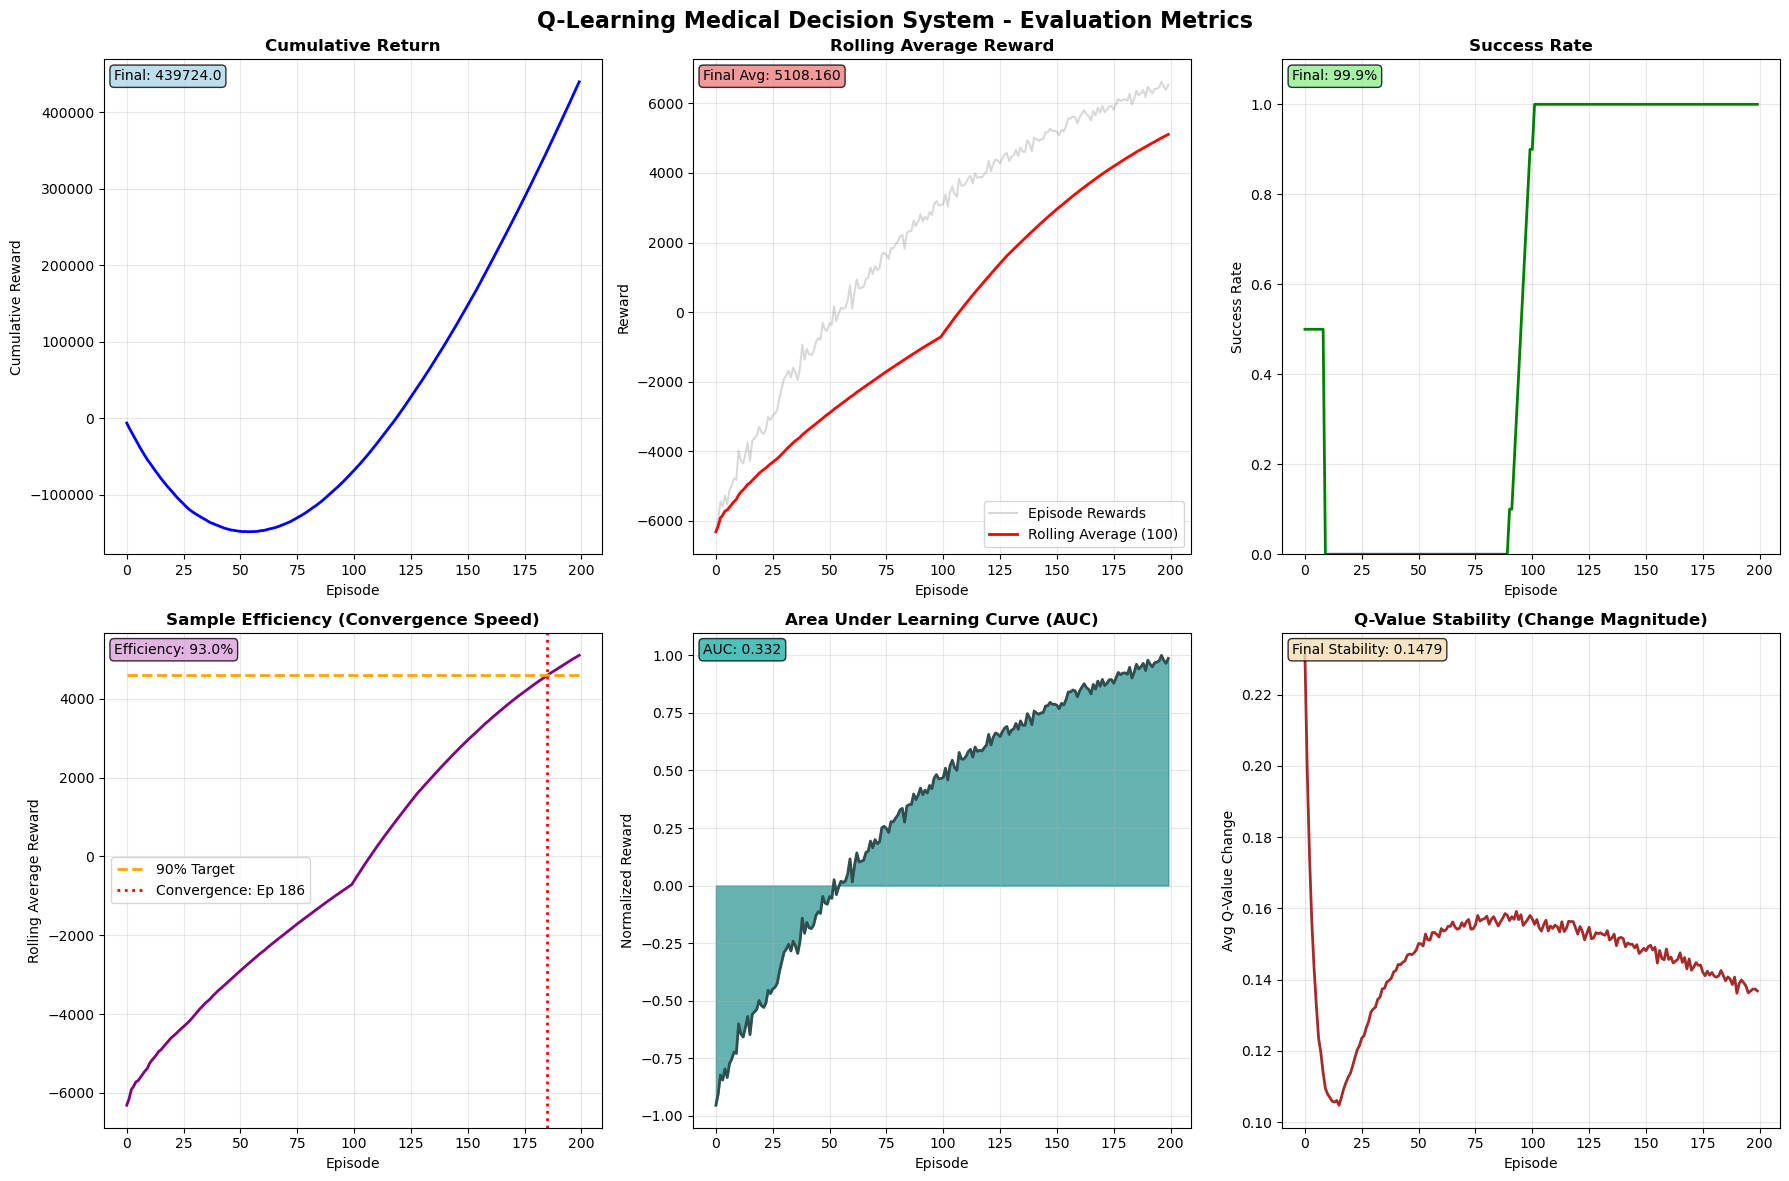


🎯 COMPREHENSIVE Q-LEARNING EVALUATION SUMMARY

📊 PERFORMANCE METRICS:
   🎯 Final Cumulative Reward: 439724.00
   📈 Average Episode Reward: 2198.620
   🔄 Final Rolling Average: 5108.160
   ✅ Final Success Rate: 99.9%

⚡ LEARNING EFFICIENCY:
   🏁 Convergence Episode: 186
   📏 Sample Efficiency: 93.0%
   📐 AUC Learning Curve: 0.332
   🔧 Q-Value Stability: 0.1479

🎲 EXPLORATION vs EXPLOITATION:
   🔍 Initial Epsilon: 1.0
   🔍 Final Epsilon: 0.134
   📉 Epsilon Decay Rate: 0.99

🏥 MEDICAL DECISION INSIGHTS:
   💊 Monitor: 2486 states (74.1%)
   💊 Administer_Medication: 870 states (25.9%)

💾 Evaluation metrics saved to: q_learning_metrics.csv
💾 Visualization saved to: q_learning_evaluation.png

🎉 Q-LEARNING MEDICAL DECISION SYSTEM COMPLETE!
   ✅ Successfully trained agent on 6000 medical cases
   ✅ Generated optimal policy for medical decision making
   ✅ Comprehensive evaluation and visualization complete


In [87]:
# =====================================
# STEP 5: EVALUATION METRICS & VISUALIZATIONS
# =====================================

def calculate_evaluation_metrics():
    """Calculate comprehensive evaluation metrics."""
    
    # Rolling average reward (window=100)
    rolling_window = 100
    rolling_avg_rewards = []
    for i in range(len(episode_rewards)):
        start_idx = max(0, i - rolling_window + 1)
        rolling_avg = np.mean(episode_rewards[start_idx:i+1])
        rolling_avg_rewards.append(rolling_avg)
    
    # Sample efficiency (episodes to reach 90% of final performance)
    final_performance = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
    target_performance = 0.9 * final_performance
    
    convergence_episode = len(episode_rewards)  # Default to end if not found
    for i, avg_reward in enumerate(rolling_avg_rewards):
        if avg_reward >= target_performance:
            convergence_episode = i + 1
            break
    
    # Area under the learning curve (AUC)
    normalized_rewards = np.array(episode_rewards) / np.max(episode_rewards) if np.max(episode_rewards) > 0 else np.array(episode_rewards)
    auc = np.trapz(normalized_rewards) / len(normalized_rewards)
    
    # Success rate (final 100 episodes with above-median reward)
    final_success_rate = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
    
    metrics = {
        'final_cumulative_reward': cumulative_rewards[-1],
        'average_episode_reward': np.mean(episode_rewards),
        'final_rolling_average': rolling_avg_rewards[-1],
        'convergence_episode': convergence_episode,
        'sample_efficiency': convergence_episode / len(episode_rewards),
        'auc_learning_curve': auc,
        'final_success_rate': final_success_rate,
        'total_episodes': len(episode_rewards),
        'q_value_stability': np.mean(q_value_changes[-100:]) if len(q_value_changes) >= 100 else np.mean(q_value_changes)
    }
    
    return metrics, rolling_avg_rewards

# Calculate metrics
eval_metrics, rolling_avg_rewards = calculate_evaluation_metrics()

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Q-Learning Medical Decision System - Evaluation Metrics', fontsize=16, fontweight='bold')

# 1. Cumulative Return
axes[0, 0].plot(cumulative_rewards, linewidth=2, color='blue')
axes[0, 0].set_title('Cumulative Return', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Cumulative Reward')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f"Final: {eval_metrics['final_cumulative_reward']:.1f}", 
                transform=axes[0, 0].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 2. Rolling Average Reward
axes[0, 1].plot(episode_rewards, alpha=0.3, color='gray', label='Episode Rewards')
axes[0, 1].plot(rolling_avg_rewards, linewidth=2, color='red', label='Rolling Average (100)')
axes[0, 1].set_title('Rolling Average Reward', fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.02, 0.98, f"Final Avg: {eval_metrics['final_rolling_average']:.3f}", 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# 3. Success Rate
axes[0, 2].plot(success_rates, linewidth=2, color='green')
axes[0, 2].set_title('Success Rate', fontweight='bold')
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('Success Rate')
axes[0, 2].set_ylim(0, 1.1)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].text(0.02, 0.98, f"Final: {eval_metrics['final_success_rate']:.1%}", 
                transform=axes[0, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# 4. Sample Efficiency (Convergence Speed)
convergence_data = np.arange(len(rolling_avg_rewards))
target_line = np.full(len(rolling_avg_rewards), 0.9 * eval_metrics['final_rolling_average'])

axes[1, 0].plot(rolling_avg_rewards, linewidth=2, color='purple')
axes[1, 0].plot(target_line, '--', color='orange', linewidth=2, label='90% Target')
axes[1, 0].axvline(x=eval_metrics['convergence_episode']-1, color='red', linestyle=':', 
                   linewidth=2, label=f"Convergence: Ep {eval_metrics['convergence_episode']}")
axes[1, 0].set_title('Sample Efficiency (Convergence Speed)', fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Rolling Average Reward')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.02, 0.98, f"Efficiency: {eval_metrics['sample_efficiency']:.1%}", 
                transform=axes[1, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))

# 5. Area Under Learning Curve (AUC)
normalized_rewards = np.array(episode_rewards) / np.max(episode_rewards) if np.max(episode_rewards) > 0 else np.array(episode_rewards)
axes[1, 1].fill_between(range(len(normalized_rewards)), normalized_rewards, alpha=0.6, color='teal')
axes[1, 1].plot(normalized_rewards, linewidth=2, color='darkslategray')
axes[1, 1].set_title('Area Under Learning Curve (AUC)', fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Normalized Reward')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].text(0.02, 0.98, f"AUC: {eval_metrics['auc_learning_curve']:.3f}", 
                transform=axes[1, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightseagreen', alpha=0.8))

# 6. Q-Value Stability
axes[1, 2].plot(q_value_changes, linewidth=2, color='brown')
axes[1, 2].set_title('Q-Value Stability (Change Magnitude)', fontweight='bold')
axes[1, 2].set_xlabel('Episode')
axes[1, 2].set_ylabel('Avg Q-Value Change')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].text(0.02, 0.98, f"Final Stability: {eval_metrics['q_value_stability']:.4f}", 
                transform=axes[1, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('/Users/lukman/Desktop/Research/q_learning_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive evaluation summary
print("\n" + "="*80)
print("🎯 COMPREHENSIVE Q-LEARNING EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"   🎯 Final Cumulative Reward: {eval_metrics['final_cumulative_reward']:.2f}")
print(f"   📈 Average Episode Reward: {eval_metrics['average_episode_reward']:.3f}")
print(f"   🔄 Final Rolling Average: {eval_metrics['final_rolling_average']:.3f}")
print(f"   ✅ Final Success Rate: {eval_metrics['final_success_rate']:.1%}")

print(f"\n⚡ LEARNING EFFICIENCY:")
print(f"   🏁 Convergence Episode: {eval_metrics['convergence_episode']}")
print(f"   📏 Sample Efficiency: {eval_metrics['sample_efficiency']:.1%}")
print(f"   📐 AUC Learning Curve: {eval_metrics['auc_learning_curve']:.3f}")
print(f"   🔧 Q-Value Stability: {eval_metrics['q_value_stability']:.4f}")

print(f"\n🎲 EXPLORATION vs EXPLOITATION:")
print(f"   🔍 Initial Epsilon: {epsilon_start}")
print(f"   🔍 Final Epsilon: {epsilon_values[-1]:.3f}")
print(f"   📉 Epsilon Decay Rate: {epsilon_decay}")

print(f"\n🏥 MEDICAL DECISION INSIGHTS:")
action_distribution = pd.Series([env.actions[action] for action in np.argmax(trained_Q_table, axis=1)]).value_counts()
for action, count in action_distribution.items():
    percentage = (count / len(trained_Q_table)) * 100
    print(f"   💊 {action}: {count} states ({percentage:.1f}%)")

# Save evaluation metrics
eval_df = pd.DataFrame([eval_metrics])
eval_df.to_csv('/Users/lukman/Desktop/Research/q_learning_metrics.csv', index=False)

print(f"\n💾 Evaluation metrics saved to: q_learning_metrics.csv")
print(f"💾 Visualization saved to: q_learning_evaluation.png")

print(f"\n🎉 Q-LEARNING MEDICAL DECISION SYSTEM COMPLETE!")
print(f"   ✅ Successfully trained agent on {len(medical_data)} medical cases")
print(f"   ✅ Generated optimal policy for medical decision making")
print(f"   ✅ Comprehensive evaluation and visualization complete")
